In [1]:
# Import useful libraries
import os
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid") # better looking plots

print("Using GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

Using backend: pytorch
Other available backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
 


Using GPU: True


# Solving the simplified BVP using DeepXDE

In this work we adress the boundary value problem introduced in [1] that has an analytical solution (considering linear elasticity).

We consider the unit square domain : $\Omega = [0,1]^2$, on which the continnum mechanics equations applies :

$ \epsilon_{ij} = \frac{1}{2}(u_{i,j}+u_{j,i}) $\
$ \sigma_{ij} =  \lambda \epsilon_{ij} \delta{ij} + 2 \mu \epsilon_{ij}$\
$ \sigma_{ij,j} + f_{i} = 0 $

The body forces are choosen on purpose so that there can be an analytical solution :

$f_x = \lambda \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 4 \pi^{2} \sin{\left(2 \pi y \right)} \cos{\left(2 \pi x \right)}\right) + \mu \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 9 \pi^{2} \sin{\left(\pi y \right)}\right)$\
$f_y = \lambda \left(- 3 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right) + \mu \left(\frac{\pi^{2} Q y^{4} \sin{\left(\pi x \right)}}{16} - 6 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right)$

We address in this notebook the simplified version of the problem, with only displacement boundary conditions. 

[1] Haghighat, Ehsan, Maziar Raissi, Adrian Moure, Hector Gomez, and Ruben Juanes. “A Deep Learning Framework for Solution and Discovery in Solid Mechanics.” 

In [2]:
# plotting utilities

def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(domain,model,output_func=None,V_exact=None,plot_diff=False,n_points=10000,fields_name=None):

    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(n_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(n_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))

    plotify = lambda x: x.reshape(Xgrid.shape)

    if output_func is None:
        V_nn = model.predict(Xinput)
    else:
        V_nn = model.predict(Xinput, operator=output_func)

    V_nn = [plotify(V) for V in V_nn]

    n_fields = len(V_nn) if type(V_nn) is list else 1
    n_plot = 1

    if fields_name is None:
        fields_name = V_exact.__name__.replace('_exact','') if V_exact is not None else 'V'

    coord = ["_x","_y","_xy"] if n_fields > 1 else [""]
    fields_name = [fields_name + coord[i] for i in range(n_fields)]

    if V_exact is not None:
        V_exact = V_exact(Xinput)
        V_exact = [plotify(V) for V in V_exact]
        n_plot = 3 if plot_diff else 2
        
    fig, ax = plt.subplots(n_fields, n_plot, figsize=(4*n_plot, 3*n_fields), dpi=200)

    for i in range(n_fields):
        subax = ax if n_fields == 1 else ax[i] 

        if V_exact is not None:

            cmax = max(V_nn[i].max(), V_exact[i].max())
            cmin = min(V_nn[i].min(), V_exact[i].min())

            im1 = pcolor_plot(subax[0], Xgrid, Ygrid, V_exact[i], f"{fields_name[i]}*", cmin=cmin, cmax=cmax)
            im2 = pcolor_plot(subax[1], Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn", cmin=cmin, cmax=cmax)

            fig.colorbar(im1, ax=subax[1])
        else:
            im1 = pcolor_plot(subax, Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn")
            fig.colorbar(im1, ax=subax)

        if plot_diff:
            diff = V_nn[i] - V_exact[i]
            abs_diff = np.abs(diff)
            cmax = abs_diff.max() if diff.max() > 0 else 0
            cmin = -abs_diff.max() if diff.min() < 0 else 0
            im3 = pcolor_plot(subax[2], Xgrid, Ygrid,diff, f"{fields_name[i]}_nn - {fields_name[i]}*", cmin=cmin, cmax=cmax, colormap="coolwarm")
            fig.colorbar(im3, ax=subax[2])
            subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")

    return fig

## Analytical solution of the boundary value problem

In [3]:
lmbd = 1.0
mu = 0.5
Q = 4.0

def U_exact(X):
    x, y = X[:,0], X[:,1]
    #displacement U
    Ux = np.cos(2*np.pi*x) * np.sin(np.pi*y)
    Uy = np.sin(np.pi*x) * Q * y**4/4
    return np.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1)))

def E_exact(X):
    #strain E
    x, y = X[:,0], X[:,1]
    Exx = -2*np.pi*np.sin(2*np.pi*x)*np.sin(np.pi*y)
    Eyy = np.sin(np.pi*x)*Q*y**3
    Exy = 0.5*(np.pi*np.cos(2*np.pi*x)*np.cos(np.pi*y) + np.pi*np.cos(np.pi*x)*Q*y**4/4)
    return (Exx, Eyy, Exy)

def S_exact(X):
    #stress S
    Sxx = (lmbd + 2*mu) * E_exact(X)[0] + lmbd * E_exact(X)[1]
    Syy = (lmbd + 2*mu) * E_exact(X)[1] + lmbd * E_exact(X)[0]
    Sxy = 2*mu*E_exact(X)[2]
    return (Sxx, Syy, Sxy)

def bodyf_exact(X):
    #body force
    x, y = X[:,0], X[:,1]
    fx = lmbd*(4*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y)-np.pi*np.cos(np.pi*x)*Q*y**3) \
        + mu*(9*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y) - np.pi*np.cos(np.pi*x)*Q*y**3)
    fy = lmbd*(-3*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y)) \
        + mu*(-6*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y) + (np.pi**2*np.sin(np.pi*x)*Q*y**4)/4)
    return (fx, fy)
    
def E_potential_exact(X):
    #potential energy
    E_strain = 1/2 * (E_exact(X)[0]*S_exact(X)[0] + E_exact(X)[1]*S_exact(X)[1] + 2*E_exact(X)[2]*S_exact(X)[2])
    W_bodyf = U_exact(X)[:,0]*bodyf_exact(X)[0] + U_exact(X)[:,1]*bodyf_exact(X)[1]
    E_potential = E_strain - W_bodyf 
    return [E_potential]

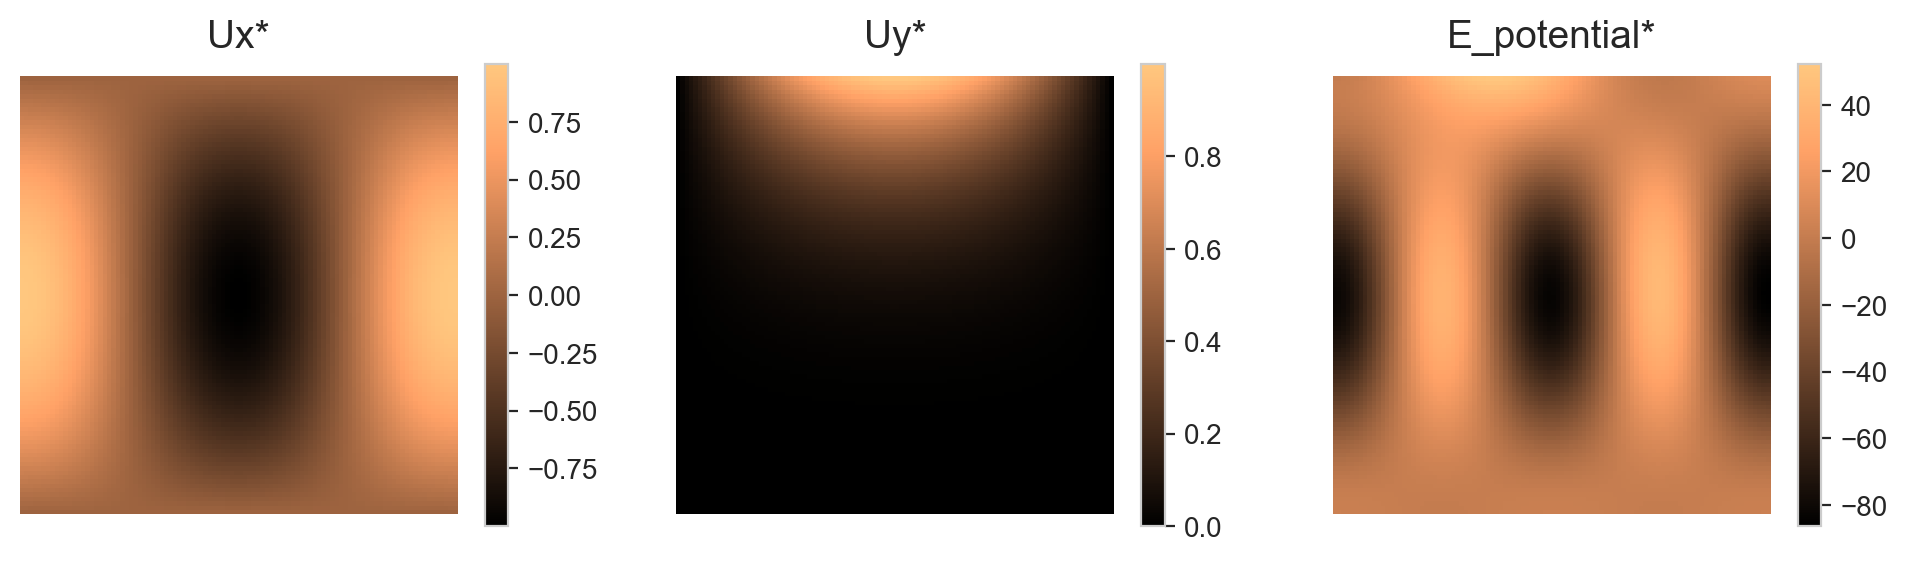

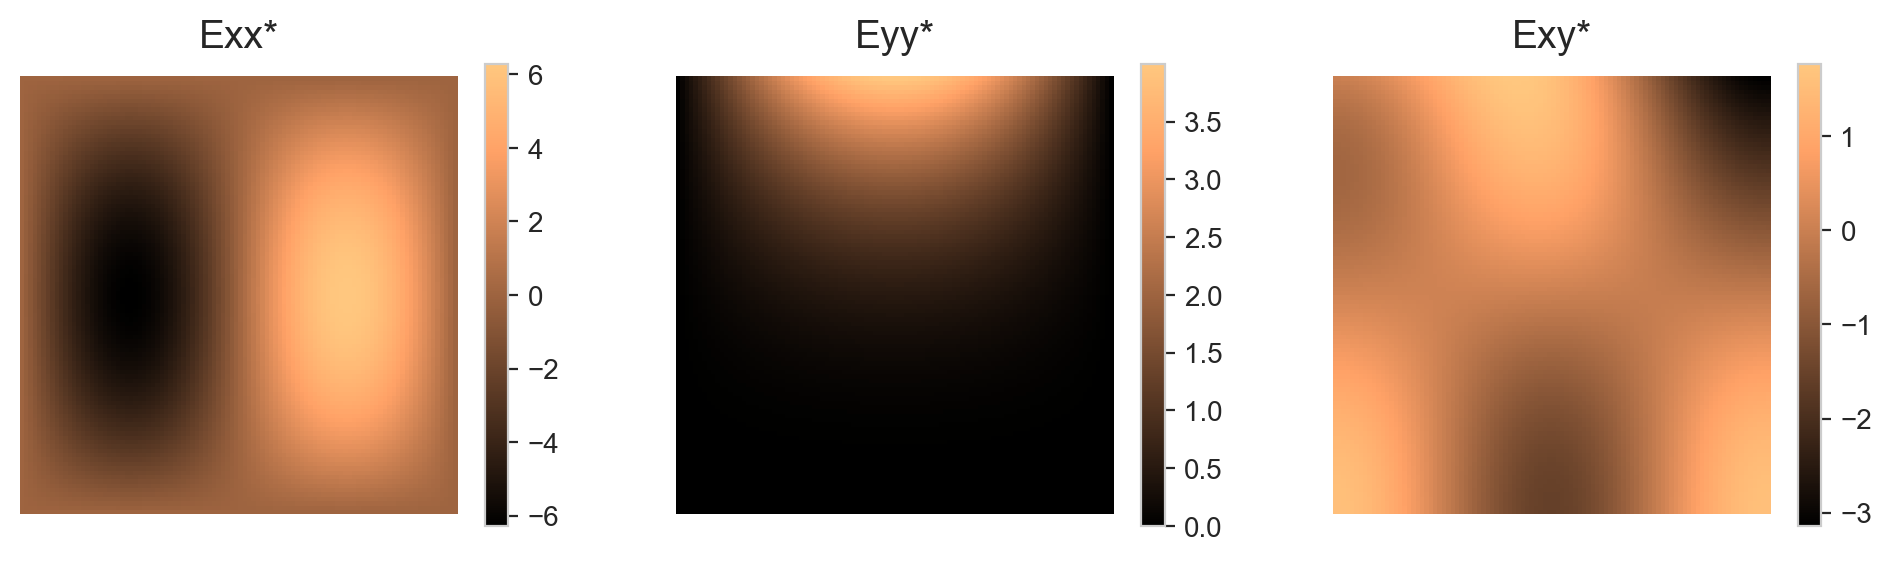

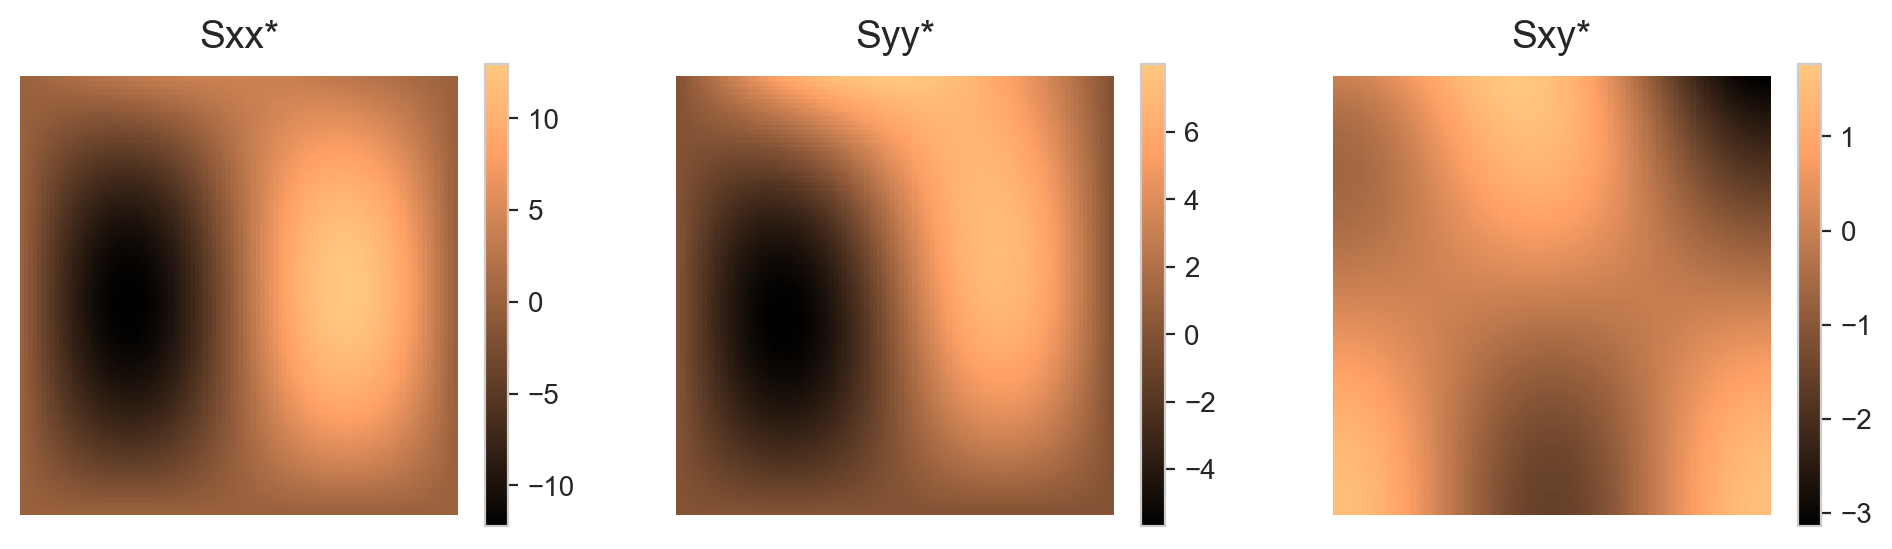

In [4]:
#plotting the analytical solution
domain = np.array([[0.0, 1.0], [0.0, 1.0]])

X = np.linspace(domain[0][0], domain[0][1], 100)
Y = np.linspace(domain[1][0], domain[1][1], 100)
Xgrid, Ygrid = np.meshgrid(X, Y)
Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(2):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, U_exact(Xinput)[:,i].reshape(Xgrid.shape), ["Ux*", "Uy*"][i])
    fig.colorbar(im, ax=ax[i])
im = pcolor_plot(ax[2], Xgrid, Ygrid, E_potential_exact(Xinput)[0].reshape(Xgrid.shape), "E_potential*")
fig.colorbar(im, ax=ax[2])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(3):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, E_exact(Xinput)[i].reshape(Xgrid.shape), ["Exx*", "Eyy*", "Exy*"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(3):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, S_exact(Xinput)[i].reshape(Xgrid.shape), ["Sxx*", "Syy*", "Sxy*"][i])
    fig.colorbar(im, ax=ax[i])

## PINN implementation with DeepXDE

In [5]:
# physical functions for tensors (output of the network) using deepxde differential operators
def bodyf(X, mu, lmbd):
    #body force
    x, y = X[:,0:1], X[:,1:2]
    fx = lmbd*(4*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y)-torch.pi*torch.cos(torch.pi*x)*Q*y**3) \
        + mu*(9*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y) - torch.pi*torch.cos(torch.pi*x)*Q*y**3)
    fy = lmbd*(-3*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y)) \
        + mu*(-6*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y) + (torch.pi**2*torch.sin(torch.pi*x)*Q*y**4)/4)
    return (fx, fy)

def E_nn(X,U):
    #calculate the strain given the displacement
    # u is the output of the NN, a tensor of shape (N,2)
    Exx = dde.grad.jacobian(U, X, i=0, j=0)
    Eyy = dde.grad.jacobian(U, X, i=1, j=1)
    Exy = 0.5 * (dde.grad.jacobian(U, X, i=1, j=0) +dde.grad.jacobian(U, X, i=0, j=1))
    return Exx, Eyy, Exy

def S_nn(E):
    #calculate the stress given the strain
    Sxx = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy = 2 * mu * E[2]
    return Sxx, Syy, Sxy

def PDE(X,S):
    """
    the PDE of the problem (momentum balance)
    X is the spatial coordinate of shape (N,2) (x,y) 
    S is the stress tensor of shape (N,3) (Sxx, Syy, Sxy)
    """

    Sxx, Syy, Sxy = S
    S = torch.stack((Sxx.reshape(-1,1), Syy.reshape(-1,1), Sxy.reshape(-1,1)), axis=1)
        
    dSxx_x = dde.grad.jacobian(S, X, i=0, j=0)
    dSyy_y = dde.grad.jacobian(S, X, i=1, j=1)
    dSxy_x = dde.grad.jacobian(S, X, i=2, j=0)
    dSxy_y = dde.grad.jacobian(S, X, i=2, j=1)
    
    fx, fy = bodyf(X, mu, lmbd)
    momentum_x = dSxx_x + dSxy_y + fx
    momentum_y = dSyy_y + dSxy_x + fy
    return [momentum_x, momentum_y]

def E_potential(U,E,S,bodyf):
    """
    calculate the potential energy of the system
    U is the displacement tensor of shape (N,2) U[:,0] = Ux, U[:,1] = Uy
    E is the strain of list of length 3 (Exx, Eyy, Exy)
    S is the stress of list of length 3 (Sxx, Syy, Sxy)
    bodyf is the body force of list of length 2 (fx, fy)
    """
    strain_energy = 0.5 * (S[0]*E[0] + S[1]*E[1] + 2*S[2]*E[2])
    bodyf_work = U[:,0:1] * bodyf[0] + U[:,1:2] * bodyf[1]
    E_pot = strain_energy - bodyf_work
    return [E_pot]

## Loss functions for the direct implementation (U as output of the network)

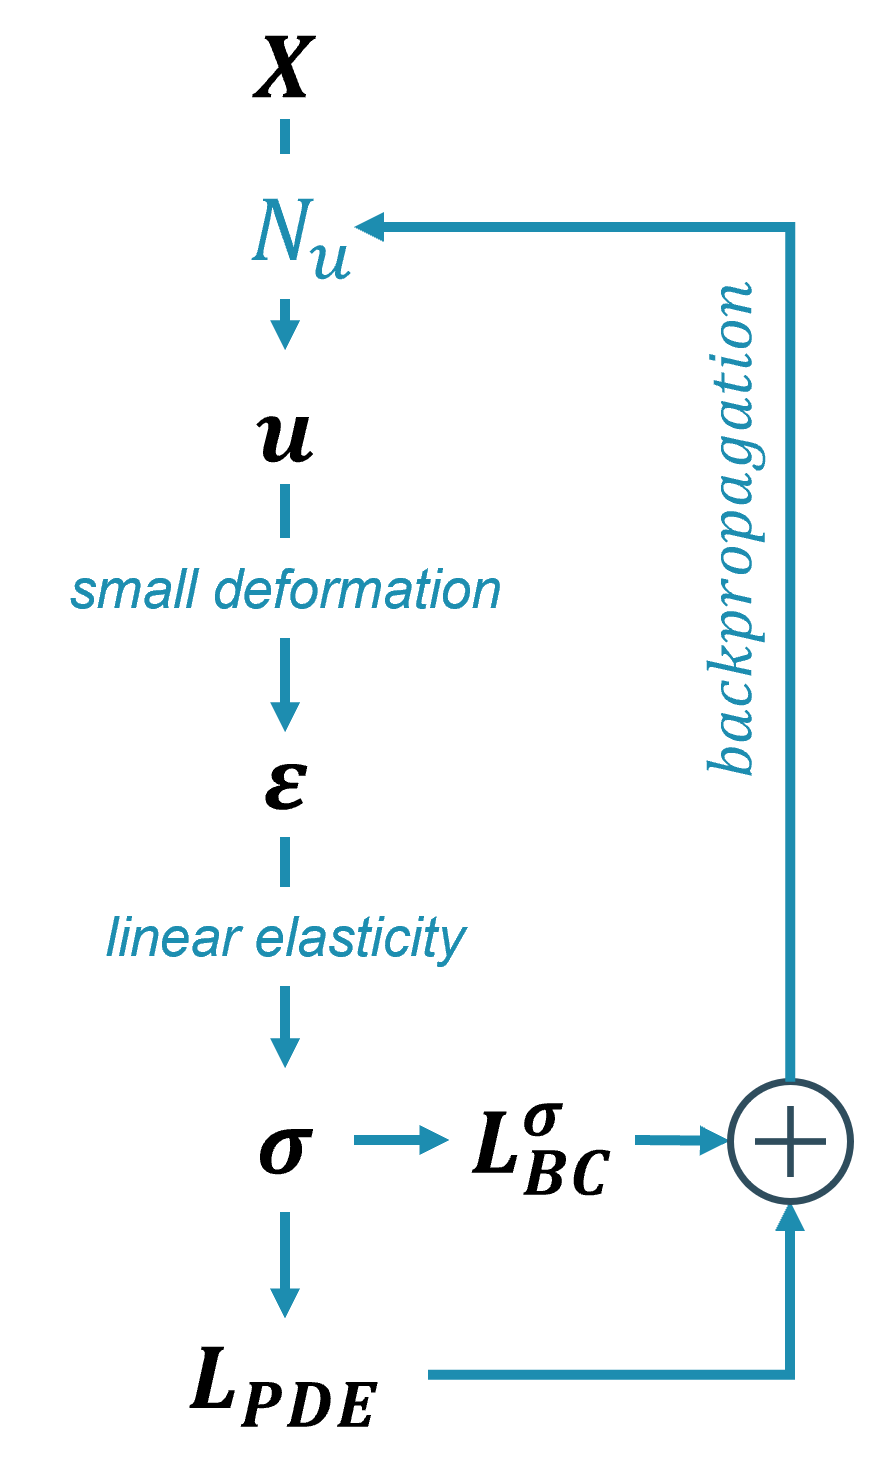

In [6]:
Image(filename=r'../figures/direct_implementation.png', width=300)

In [7]:
def PDE_loss(x,u):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    u: output tensor of shape (N,2), the displacement u_x and u_y
    return: the PDE loss
    """
    E = E_nn(x,u)
    S = S_nn(E)
    pde = PDE(x,S)
    return pde

def E_potential_loss(x,u):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    u: output tensor of shape (N,2), the displacement u_x and u_y
    return: the potential energy
    """
    E = E_nn(x,u)
    S = S_nn(E)
    bodyf_val = bodyf(x, mu, lmbd)
    E_pot = E_potential(u,E,S,bodyf_val)
    return E_pot

def Enforce_BC(x,u):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    u: output tensor of shape (N,2), the displacement u_x and u_y
    return: U tensor of shape (N,2) that respects the boundary conditions
    """
    Weight_func = lambda X,Y: X * (1 - X) * Y * (1 - Y)
    Ux = u[:,0]*Weight_func(x[:,0],x[:,1]) + torch.sin(torch.pi*x[:,1])
    Uy = u[:,1]*Weight_func(x[:,0],x[:,1]) + x[:,1]*torch.sin(torch.pi*x[:,0])
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

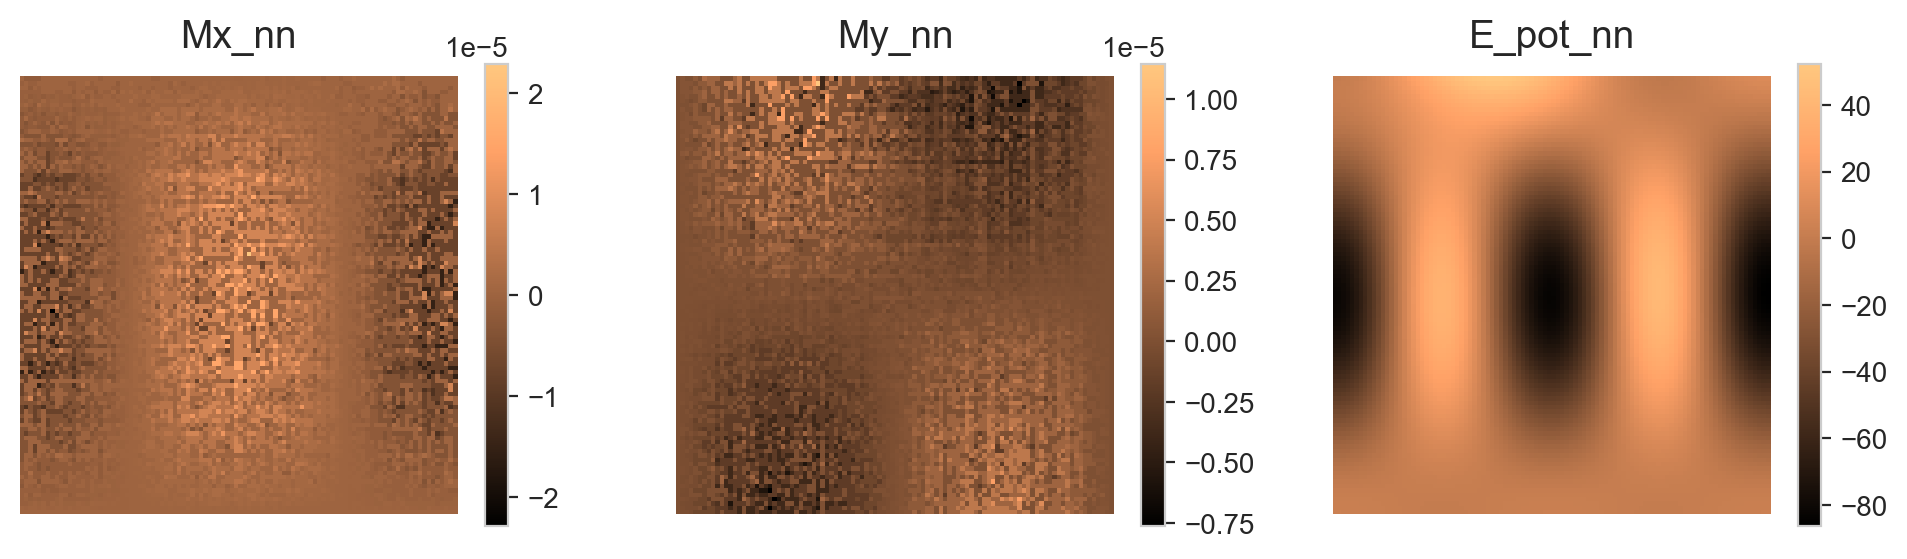

In [8]:
#check the loss function on the exact solution
X = np.linspace(domain[0][0], domain[0][1], 100)
Y = np.linspace(domain[1][0], domain[1][1], 100)
Xgrid, Ygrid = np.meshgrid(X, Y)
Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
Xtorch = torch.from_numpy(Xinput).float().to(device)
Xtorch.requires_grad = True

def NN_exact(x):
    # ground truth displacement
    Ux = torch.cos(2*torch.pi*x[:,0]) * torch.sin(torch.pi*x[:,1])
    Uy = torch.sin(torch.pi*x[:,0]) * Q * x[:,1]**4/4
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 


PDE_test = PDE_loss(Xtorch,NN_exact(Xtorch))
E_pot_test = E_potential_loss(Xtorch,NN_exact(Xtorch))

fig, ax = plt.subplots(1,3, figsize=(12, 3), dpi=200)
im = pcolor_plot(ax[0], Xgrid, Ygrid, PDE_test[0].detach().cpu().reshape(Xgrid.shape), "Mx_nn")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], Xgrid, Ygrid, PDE_test[1].detach().cpu().reshape(Xgrid.shape), "My_nn")
fig.colorbar(im, ax=ax[1])
im = pcolor_plot(ax[2], Xgrid, Ygrid, E_pot_test[0].detach().cpu().reshape(Xgrid.shape), "E_pot_nn")
fig.colorbar(im, ax=ax[2])

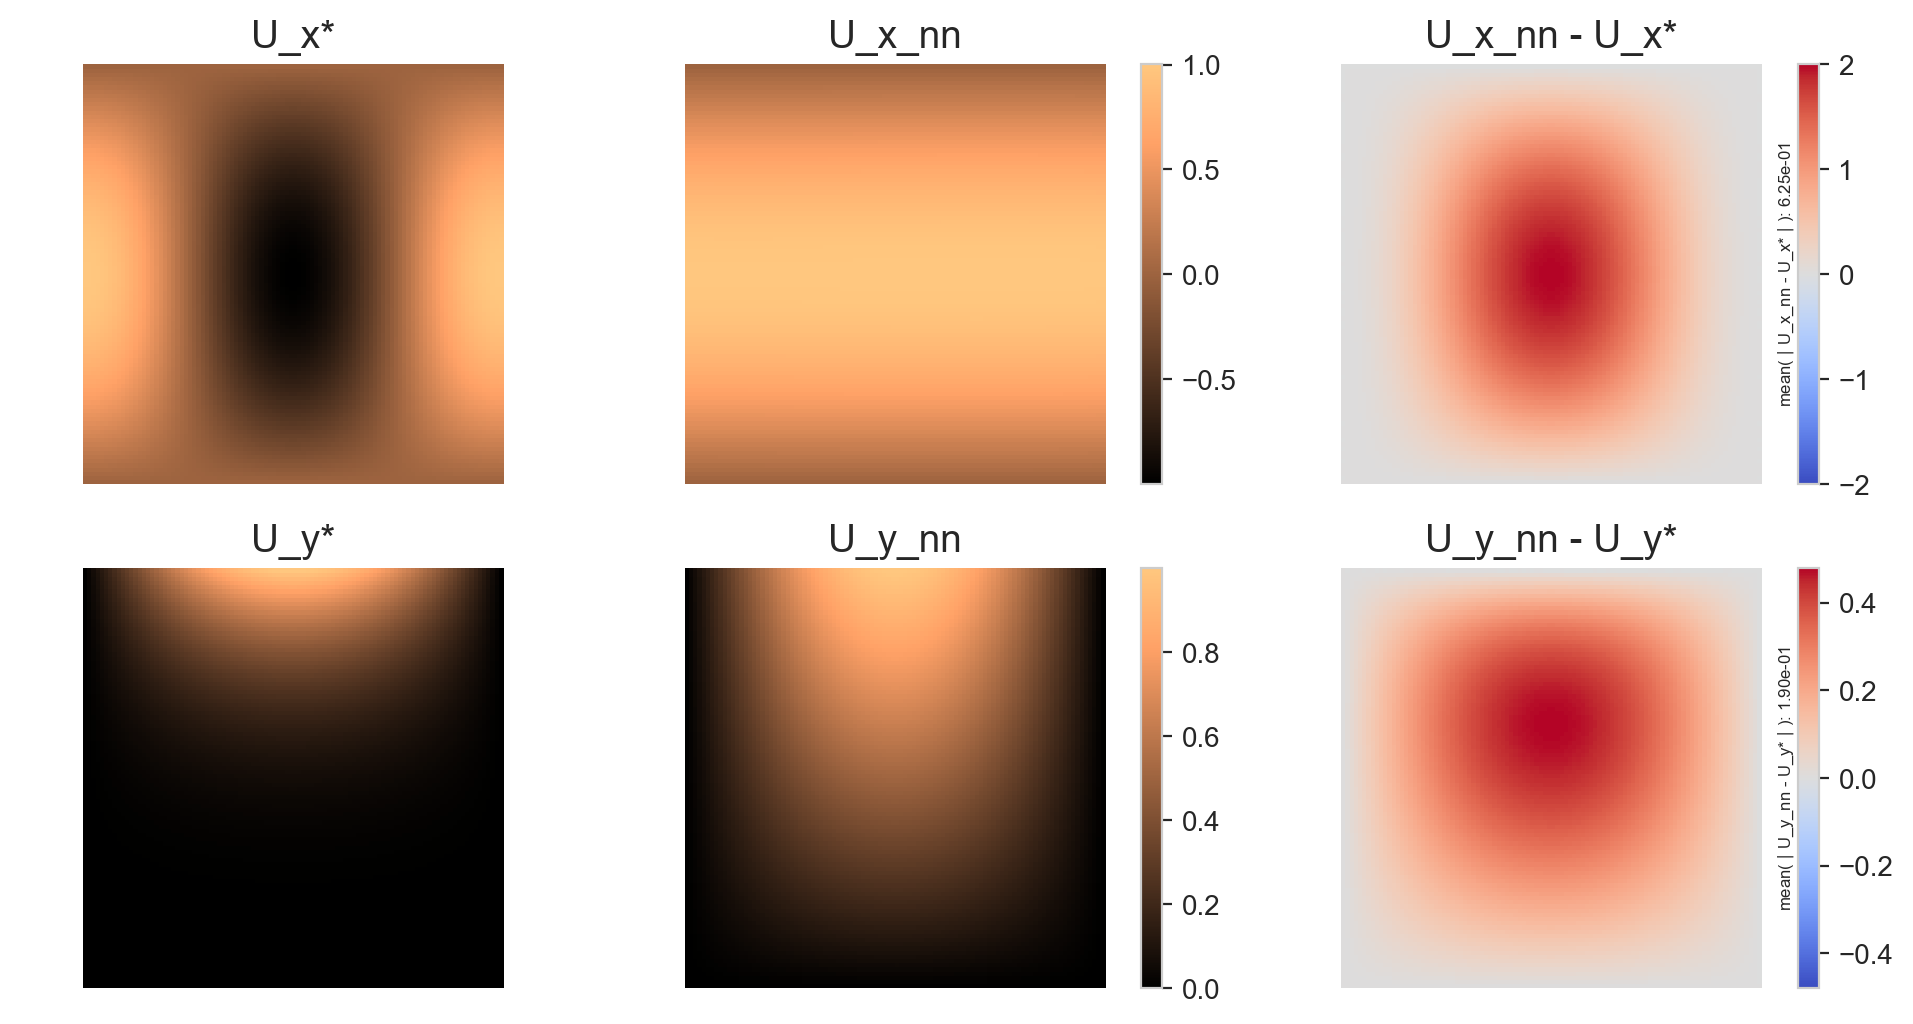

In [22]:
geom = dde.geometry.Rectangle([0, 0], [1, 1])
bc = [] # hard constraint
num_domain = 2000
Phy_loss = [PDE_loss,E_potential_loss][0] #the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following

data = dde.data.PDE(
    geom,
    Phy_loss,
    bc,
    num_domain=num_domain,
    num_test= num_domain,
    solution=U_exact,
)

net = dde.nn.FNN([2] + 4 * [50] + [2], "tanh", "Glorot normal")
net.apply_output_transform(Enforce_BC)

model = dde.Model(data, net)

# sanity check that BCs are enforced
U_output = lambda x, u: (u[:,0], u[:,1]) 
fig = plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")

In [23]:
#train model
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
model.train(iterations=3000)

model.compile("L-BFGS", metrics=["l2 relative error"])
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000398 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.79e+03, 2.93e+02]    [1.79e+03, 2.93e+02]    [1.67e+00]    


KeyboardInterrupt: 

Saving loss history to results/simplified_BVP/loss_history ...


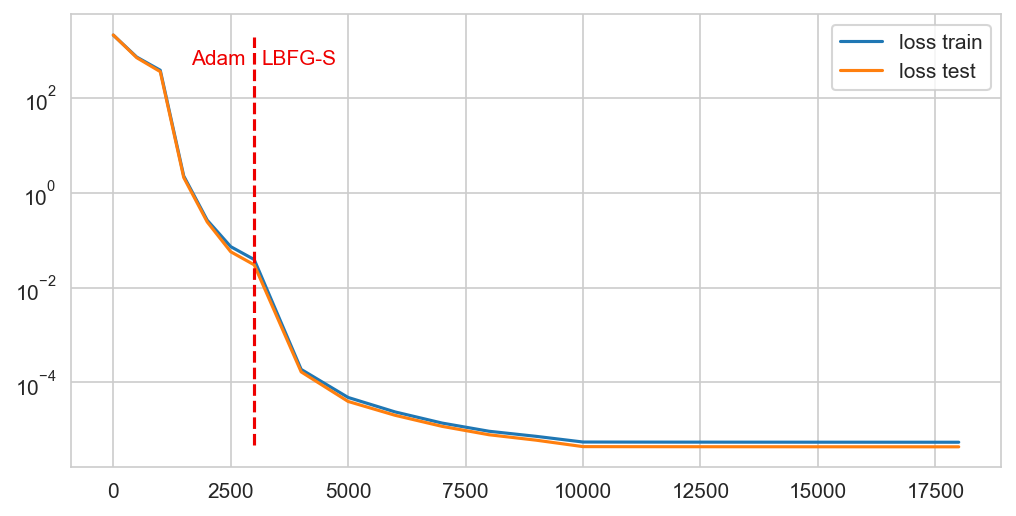

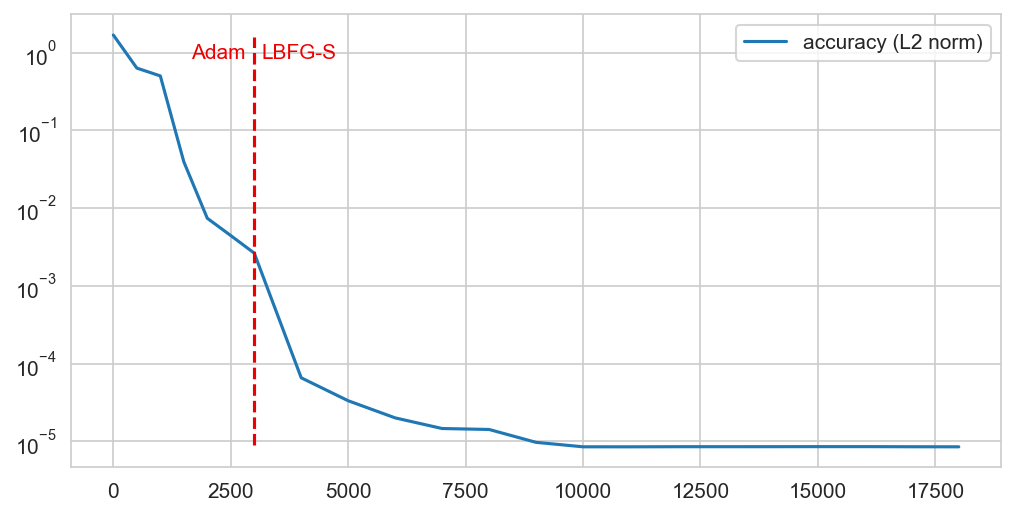

In [20]:
#plotting the loss history and save run
steps = np.array(losshistory.steps).squeeze()
losses_train = np.array(losshistory.loss_train).squeeze().sum(axis=1)
losses_test =  np.array(losshistory.loss_test).squeeze().sum(axis=1)
metrics =  np.array(losshistory.metrics_test).squeeze()

loss_plot = plt.figure(figsize = (8,4),dpi = 150)
plt.plot(steps,losses_train,steps,losses_test)
plt.yscale('log')
plt.legend(["loss train","loss test"])
plt.axvline(x=3000, ymin=0.05, ymax=0.95, color='#EE0000',ls='--',label="Change optimizer")
plt.text(1650, 500, 'Adam',color="#EE0000")
plt.text(3150, 500, 'LBFG-S',color="#EE0000")

accuracy_plot = plt.figure(figsize = (8,4),dpi = 150)
plt.plot(steps,metrics)
plt.yscale('log')
plt.legend(["accuracy (L2 norm)"])
plt.axvline(x=3000, ymin=0.05, ymax=0.95, color='#EE0000',ls='--')
plt.text(1650, 0.85, 'Adam',color="#EE0000")
plt.text(3150, 0.85, 'LBFG-S',color="#EE0000")

fname = r"results/simplified_BVP/" #folder to save results (should exist)
save_run = True
if save_run:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
    model.train(iterations=0,model_save_path=os.path.join(fname, "model"))
    
    dde.utils.external.save_loss_history(losshistory, os.path.join(fname,'loss_history'))
    loss_plot.savefig(os.path.join(fname,"loss_history_simplified_BVP.png"), dpi=150)
    accuracy_plot.savefig(os.path.join(fname,"accuracy_history_simplified_BVP.png"), dpi=150)

Saving loss history to results/simplified_BVP/loss_history ...
Compiling model...
'compile' took 0.001045 s

Training model...

Step      Train loss              Test loss               Test metric   
18000     [3.36e-06, 2.15e-06]    [2.74e-06, 1.67e-06]    [8.53e-06]    

Best model at step 18000:
  train loss: 5.51e-06
  test loss: 4.41e-06
  test metric: [8.53e-06]

Epoch 18000: saving model to results/simplified_BVP/model-18000.pt ...

'train' took 0.080807 s



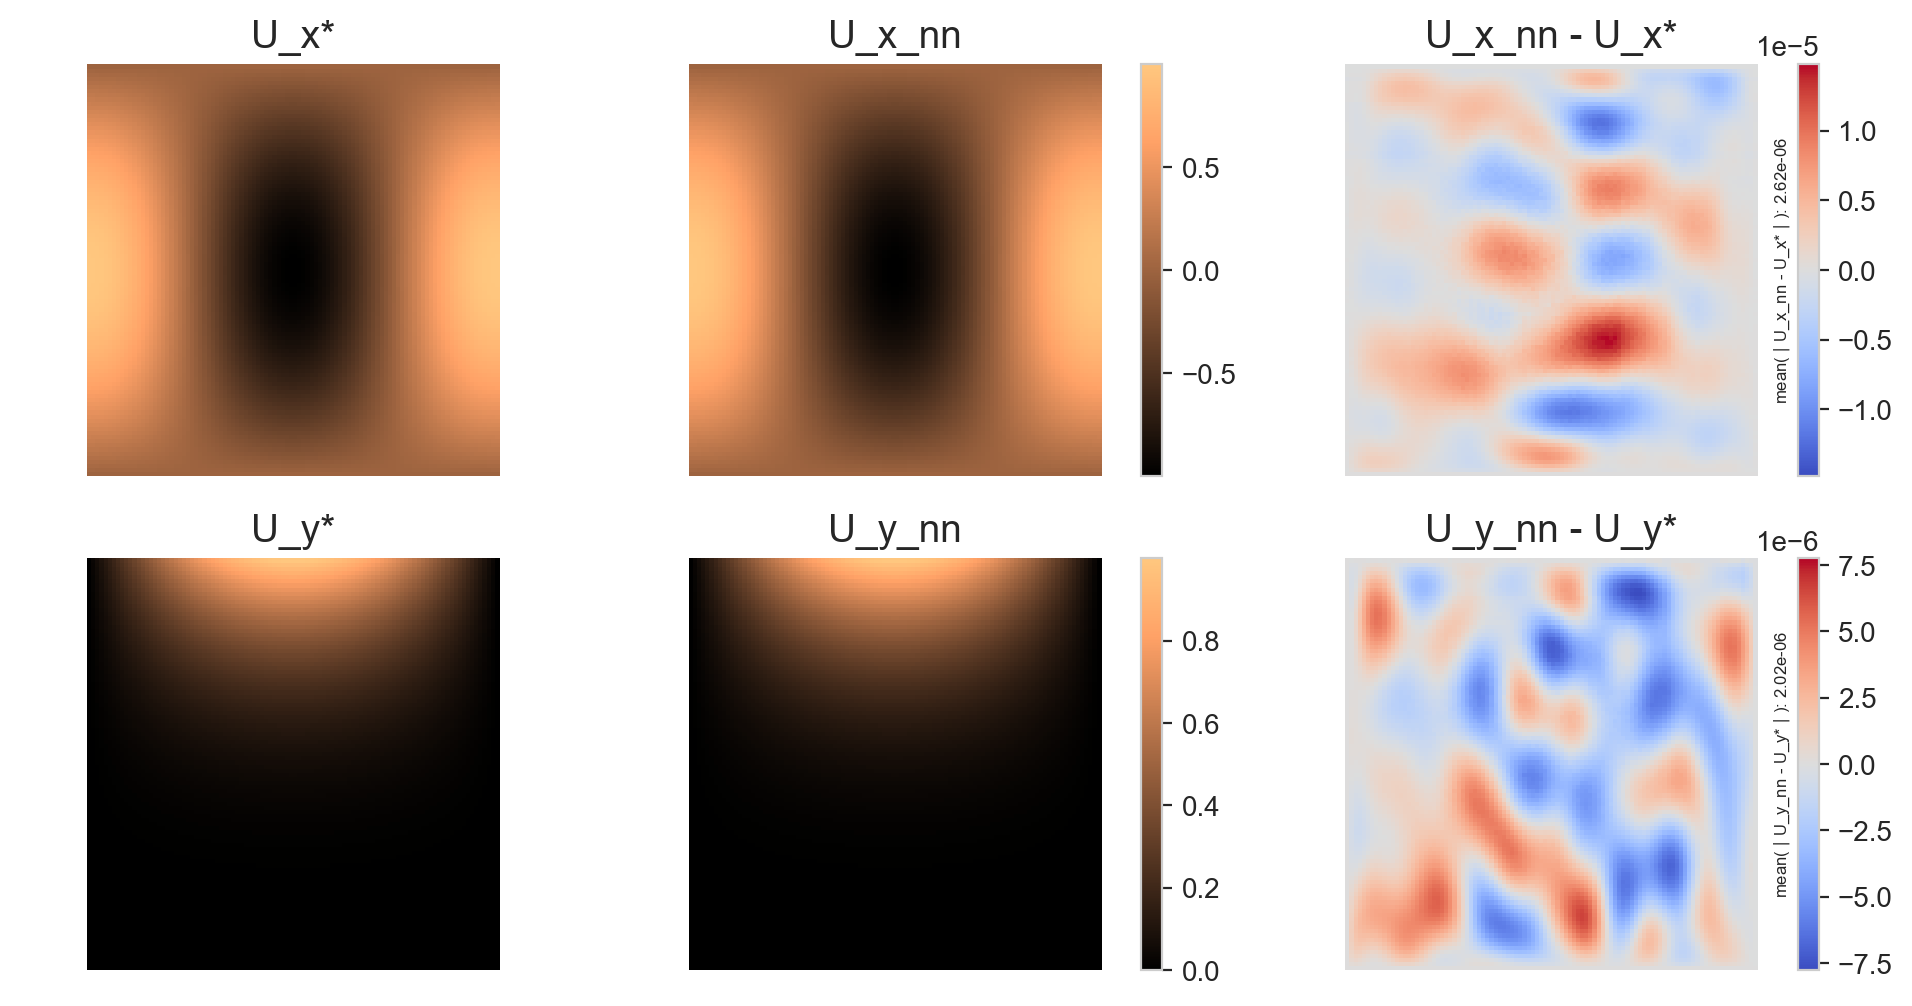

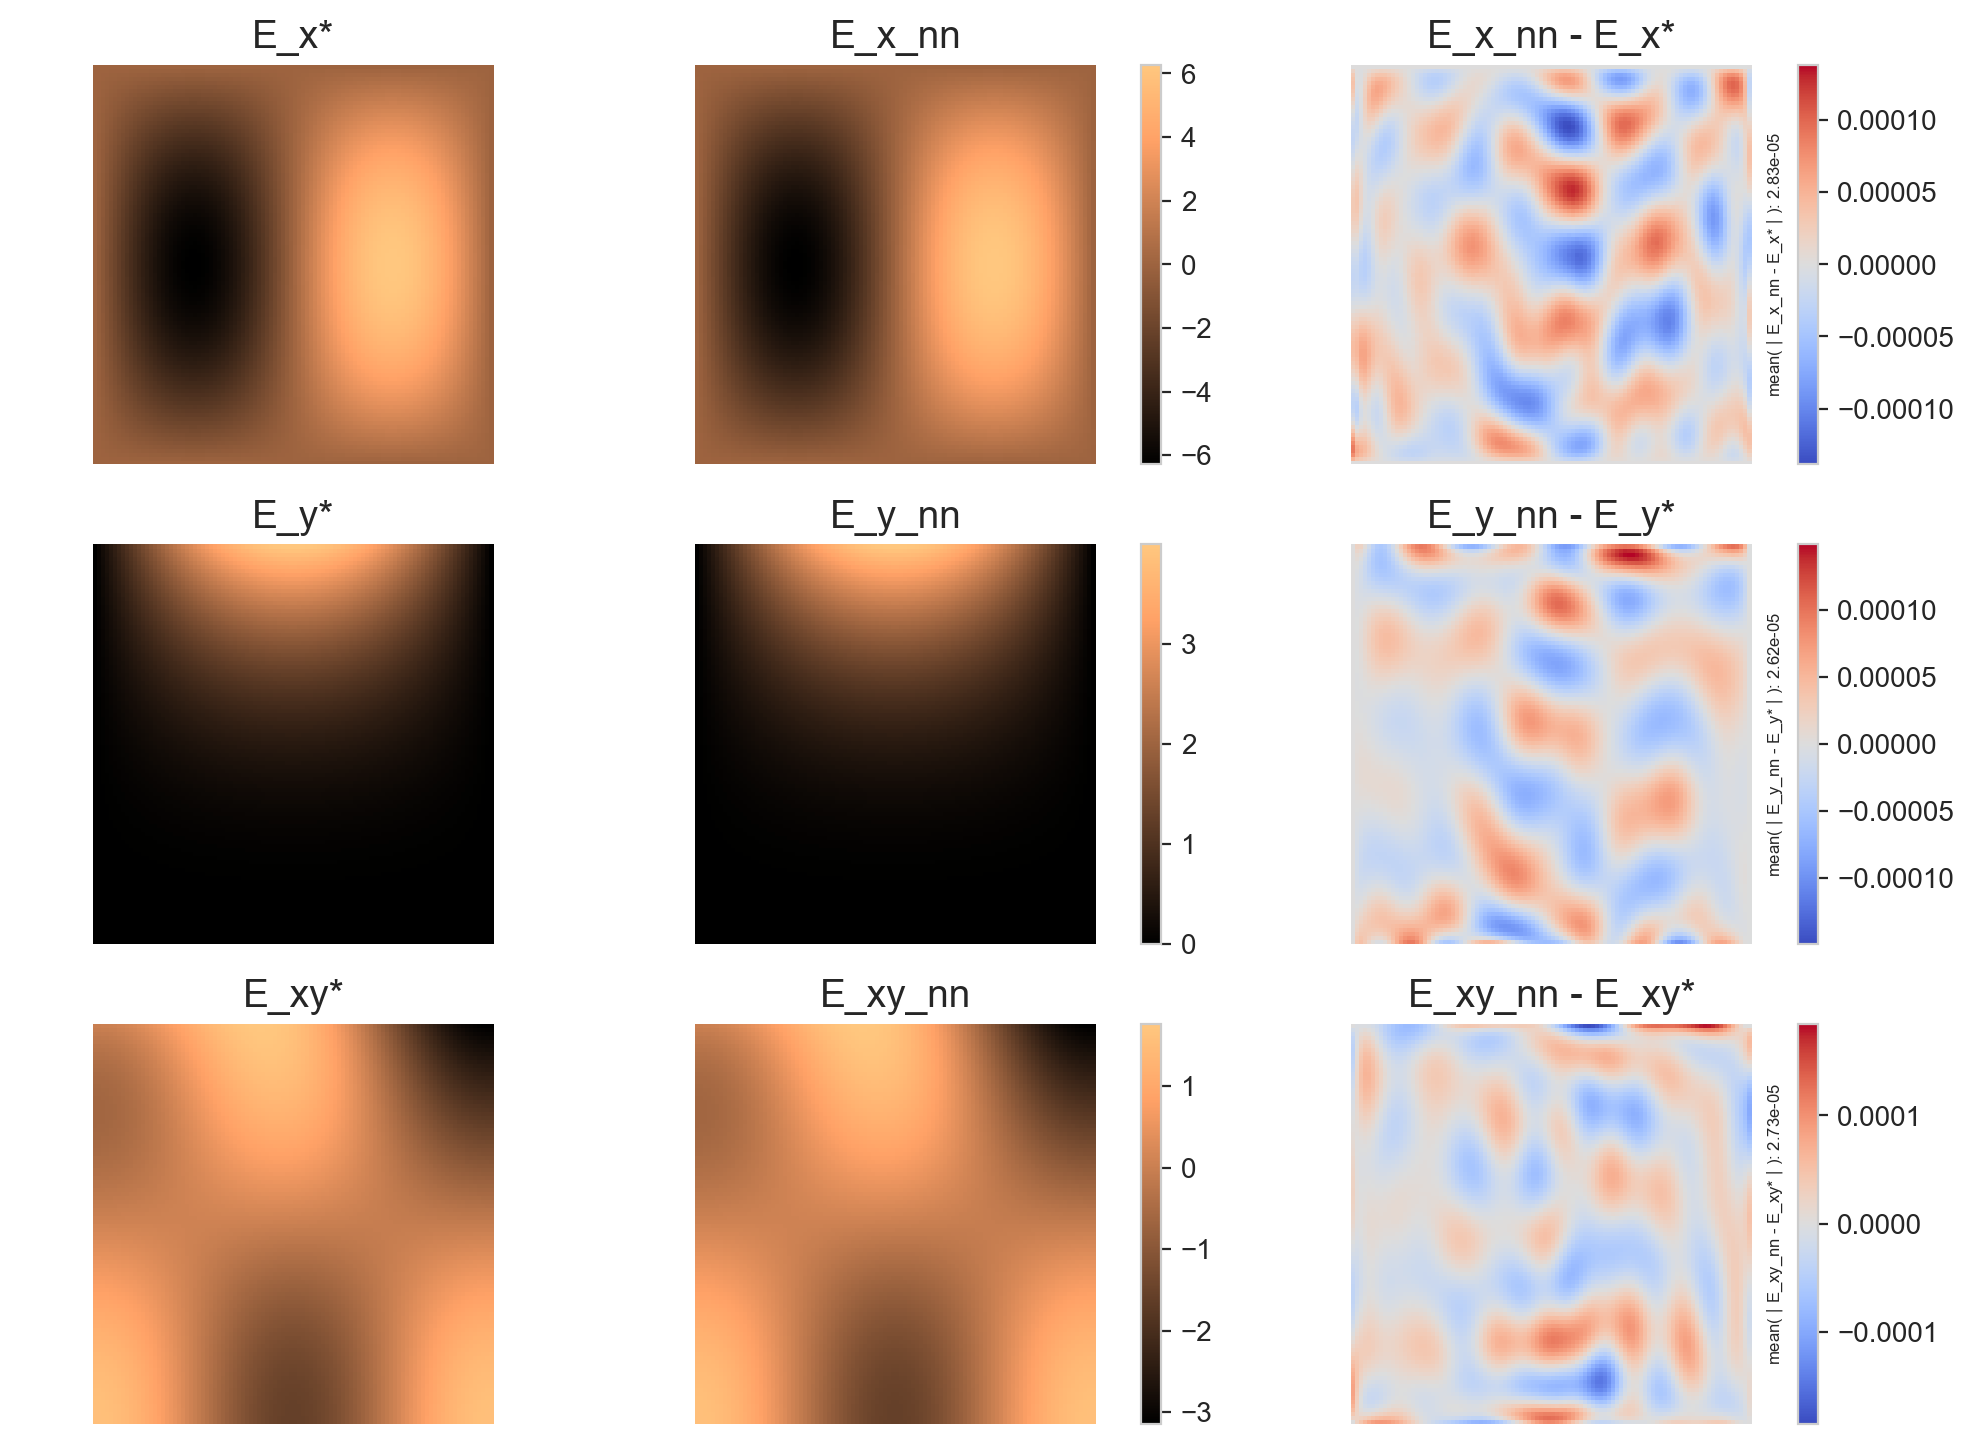

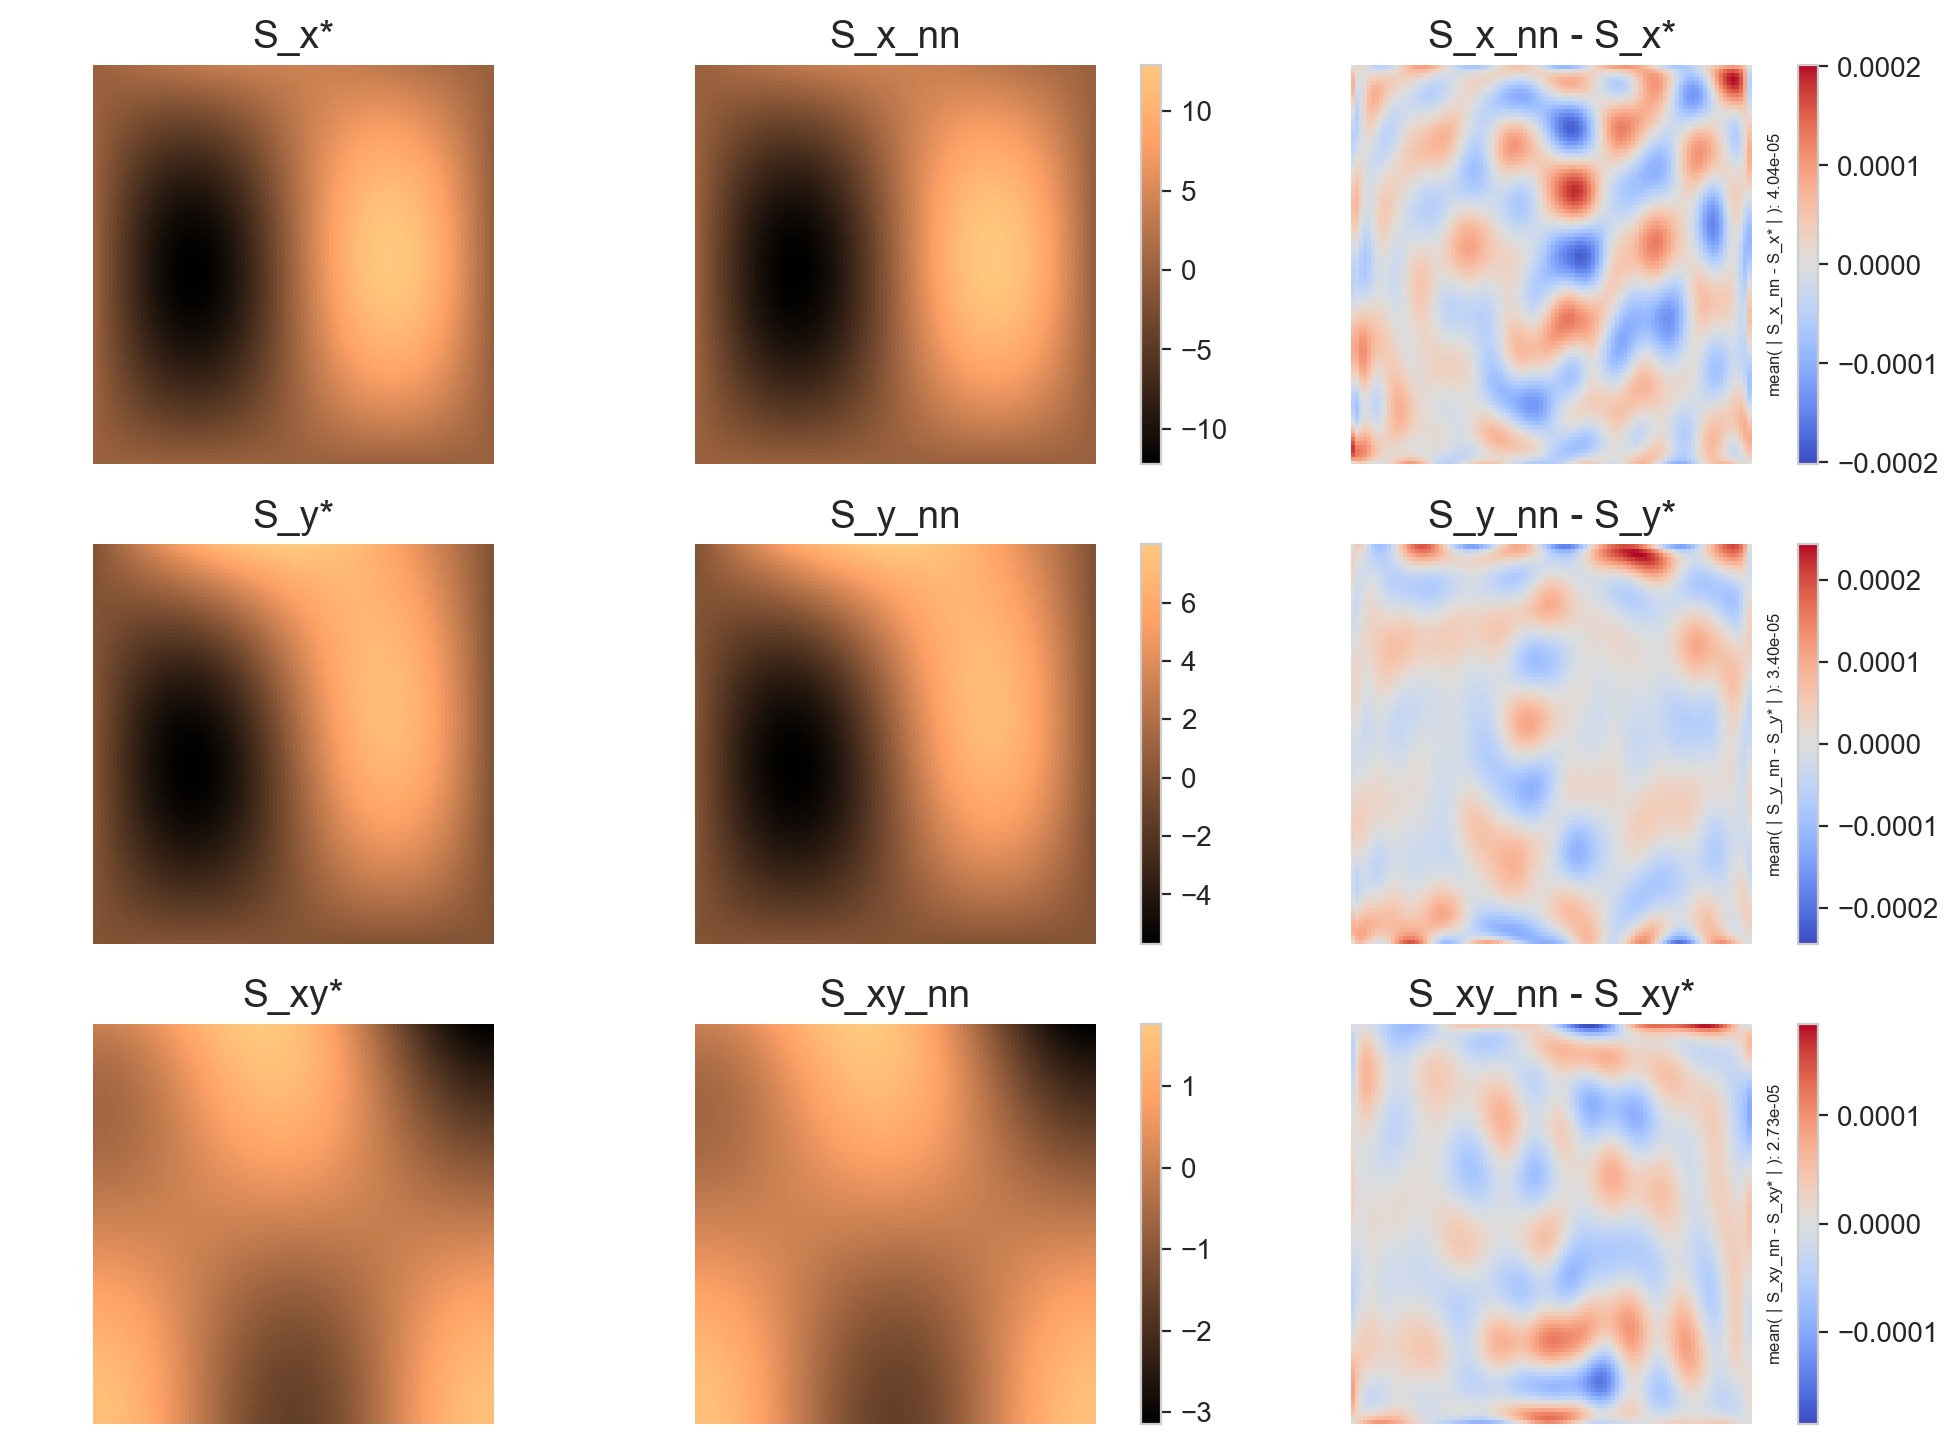

In [19]:
save_plot = True

U_output = lambda x, u: (u[:,0], u[:,1]) 
S_output = lambda x, u: S_nn(E_nn(x,u))

U_plot = plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
E_plot = plot_field(domain,model,output_func=E_nn,V_exact=E_exact,plot_diff=True)
S_plot = plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True)

if save_plot:
    U_plot.savefig(os.path.join(fname,"U_simplified_BVP.png"), dpi=150)
    E_plot.savefig(os.path.join(fname,"E_simplified_BVP.png"), dpi=150)
    S_plot.savefig(os.path.join(fname,"S_simplified_BVP.png"), dpi=150)

# Assess stochasticity of the optimization
We perform 20 optimizations with the same hyperparameters to assess the stochasticity of the optimization.

In [18]:
# choosing a configuration
#net parameters
net_type= 'Simplified_NN'
n_layers= 3
size_layers= 100
activation= 'tanh'

#loss parameters
loss_type= ['pde','energy'][0]#the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following
num_samples= 100
train_distribution= 'Hammersley'

#boundary conditions
bc_type= 'hard'

#optimizer
optimizers= ["adam","L-BFGS"]
learning_rates= [1e-3,None]
iterations= [3000,None]

configuration = {'net_type':net_type,'n_layers':n_layers,'size_layers':size_layers,'activation':activation,
        'loss_type':loss_type,'num_samples':num_samples,'train_distribution':train_distribution,
        'bc_type':bc_type,
        'optimizers':optimizers,'learning_rates':learning_rates,'iterations':iterations}

In [20]:
import wandb

def train_model(model,config,callbacks = [],model_save_path = None):
    learning_rates = config['learning_rates']
    optimizers = config['optimizers']
    iterations = config['iterations']
    
    for i,optimizer in enumerate(optimizers) :    
        if optimizer == "adam":
            model.compile("adam", lr=learning_rates[i], metrics=["l2 relative error"])
            losshistory, train_state  = model.train(iterations=iterations[i],callbacks = callbacks,model_save_path=model_save_path)
        elif optimizer == "L-BFGS":
            model.compile("L-BFGS", metrics=["l2 relative error"])
            losshistory, train_state  = model.train(callbacks = callbacks,model_save_path=model_save_path)
    return losshistory, train_state

def log_run(config,losshistory):
    """Log the run to wandb"""
    steps = np.array(losshistory.steps).squeeze() 
    losses_train = np.array(losshistory.loss_train).squeeze().sum(axis=1)
    losses_test = np.array(losshistory.loss_test).squeeze().sum(axis=1)
    metrics = np.array(losshistory.metrics_test).squeeze()

    for i in range(len(steps)):
        wandb.log({"steps": steps[i], "loss_train": losses_train[i], "loss_test": losses_test[i], "accuracy_metric": metrics[i]})
        
def wandb_train(config=None):
    with wandb.init(project="HPO-PINN-CM", config=config):
        config = wandb.config
        num_domain = config["num_samples"]**2

        data = dde.data.PDE(
            geom,
            PDE_loss,
            [],
            num_domain=num_domain,
            num_test = num_domain,
            solution=U_exact,
        )

        net = dde.nn.FNN([2] + [config["size_layers"]] * config["n_layers"] + [2], config["activation"],'Glorot uniform')
        net.apply_output_transform(Enforce_BC)

        model = dde.Model(data, net)
        model_save_path = os.path.join(wandb.run.dir, "model") if save_model else None
        losshistory, train_state = train_model(model,config,model_save_path=model_save_path)
        log_run(config,losshistory)
        

In [20]:
dde.optimizers.config.set_LBFGS_options(maxiter=10000)
save_model = True
nb_runs = 25
geom = dde.geometry.Rectangle([0, 0], [1, 1])

for run in range(nb_runs):
    wandb_train(config=configuration)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: damien-bonnet. Use `wandb login --relogin` to force relogin


Compiling model...
'compile' took 0.000911 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.79e+03, 2.90e+02]    [1.79e+03, 2.90e+02]    [1.64e+00]    


# Hyperparameter optimization with Weights and Biases

In [23]:
# Initialize the wandb sweep with the possible values for the hyperparameters
sweep_dict = {
    'net_type': {'value': 'Simplified_NN'},
    'n_layers': { 'min': 2,'max': 4},
    'size_layers': {'values': [20,30,40]},#[50,75,100]},
    'activation': {'values': ['tanh','sigmoid']},
    'loss_type': {'value':  'pde'},
    'num_samples': {'values': [25,50,75,100]},
    'bc_type': {'value': 'hard'},
    'train_distribution': {'value': 'Hammersley'},
    'optimizers': {'value': ["adam","L-BFGS"]},
    'learning_rates': {'value': [1e-3,None]},
    'iterations': {'value': [3000,None]}
}

sweep_config = {
    'method': 'grid',
    'parameters': sweep_dict,
#     'metric': {
#         'name': 'accuracy_metric',
#         'goal': 'minimize'   
#     },
    'name': 'simplified-BVP-grid',
    }

project_name = 'HPO-PINN-CM'
sweep_id = wandb.sweep(sweep_config, project=project_name)

Create sweep with ID: 2gqlvrag
Sweep URL: https://wandb.ai/damien-bonnet/HPO-PINN-CM/sweeps/2gqlvrag


In [25]:
dde.optimizers.config.set_LBFGS_options(maxiter=10000)
geom = dde.geometry.Rectangle([0, 0], [1, 1])
save_model = False
count=6
wandb.agent(sweep_id, wandb_train, count=count)

wandb: Agent Starting Run: zohlol46 with config:
wandb: 	activation: tanh
wandb: 	bc_type: hard
wandb: 	iterations: [3000, None]
wandb: 	learning_rates: [0.001, None]
wandb: 	loss_type: pde
wandb: 	n_layers: 3
wandb: 	net_type: Simplified_NN
wandb: 	num_samples: 100
wandb: 	optimizers: ['adam', 'L-BFGS']
wandb: 	size_layers: 30
wandb: 	train_distribution: Hammersley
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Compiling model...
'compile' took 0.001094 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.79e+03, 2.93e+02]    [1.79e+03, 2.93e+02]    [1.65e+00]    
1000      [5.94e+02, 1.84e+01]    [5.84e+02, 1.71e+01]    [5.61e-01]    
2000      [4.25e+02, 1.04e+01]    [4.14e+02, 9.46e+00]    [4.94e-01]    
3000      [1.56e+02, 5.34e+00]    [1.46e+02, 5.02e+00]    [3.51e-01]    

Best model at step 3000:
  train loss: 1.61e+02
  test loss: 1.51e+02
  test metric: [3.51e-01]

'train' took 227.051897 s

Compiling model...
'compile' took 0.001158 s

Training model...

Step      Train loss              Test loss               Test metric   
3000      [1.56e+02, 5.34e+00]    [1.46e+02, 5.02e+00]    [3.51e-01]    
4000      [8.45e-04, 8.98e-04]    [7.40e-04, 8.13e-04]    [4.45e-04]    
5000      [2.23e-04, 1.66e-04]    [1.99e-04, 1.46e-04]    [1.47e-04]    
6000      [1.14e-04, 1.01e-04]    [9.72e-05, 9.31e-05]    [1.02e-04]    
7000      [7.98

accuracy_metric,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁
loss_test,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
loss_train,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
steps,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█
accuracy_metric,3e-05
loss_test,2e-05
loss_train,3e-05
steps,13000


wandb: Agent Starting Run: x45tojyi with config:
wandb: 	activation: tanh
wandb: 	bc_type: hard
wandb: 	iterations: [3000, None]
wandb: 	learning_rates: [0.001, None]
wandb: 	loss_type: pde
wandb: 	n_layers: 3
wandb: 	net_type: Simplified_NN
wandb: 	num_samples: 100
wandb: 	optimizers: ['adam', 'L-BFGS']
wandb: 	size_layers: 40
wandb: 	train_distribution: Hammersley
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Compiling model...
'compile' took 0.001054 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.79e+03, 2.96e+02]    [1.79e+03, 2.96e+02]    [1.65e+00]    
1000      [8.99e+02, 2.63e+01]    [8.93e+02, 2.46e+01]    [6.90e-01]    
2000      [5.05e+02, 8.43e+00]    [4.94e+02, 7.53e+00]    [5.74e-01]    
3000      [2.72e+01, 3.86e+00]    [2.38e+01, 3.78e+00]    [1.88e-01]    

Best model at step 3000:
  train loss: 3.10e+01
  test loss: 2.76e+01
  test metric: [1.88e-01]

'train' took 226.544515 s

Compiling model...
'compile' took 0.001198 s

Training model...

Step      Train loss              Test loss               Test metric   
3000      [2.72e+01, 3.86e+00]    [2.38e+01, 3.78e+00]    [1.88e-01]    
4000      [4.05e-04, 2.74e-04]    [3.71e-04, 2.47e-04]    [2.05e-04]    
5000      [8.16e-05, 7.82e-05]    [7.29e-05, 6.94e-05]    [7.83e-05]    
6000      [3.93e-05, 3.79e-05]    [3.59e-05, 3.35e-05]    [4.26e-05]    
7000      [2.77

accuracy_metric,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
loss_test,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁
steps,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█
accuracy_metric,1e-05
loss_test,1e-05
loss_train,1e-05
steps,13000


wandb: Agent Starting Run: 01u5ovkc with config:
wandb: 	activation: tanh
wandb: 	bc_type: hard
wandb: 	iterations: [3000, None]
wandb: 	learning_rates: [0.001, None]
wandb: 	loss_type: pde
wandb: 	n_layers: 4
wandb: 	net_type: Simplified_NN
wandb: 	num_samples: 25
wandb: 	optimizers: ['adam', 'L-BFGS']
wandb: 	size_layers: 20
wandb: 	train_distribution: Hammersley
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Compiling model...
'compile' took 0.000866 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.79e+03, 2.94e+02]    [1.81e+03, 2.96e+02]    [1.73e+00]    
1000      [6.16e+02, 2.47e+01]    [5.81e+02, 2.14e+01]    [7.09e-01]    
2000      [4.13e+02, 1.13e+01]    [3.67e+02, 8.82e+00]    [5.30e-01]    
3000      [1.13e+02, 8.48e+00]    [1.06e+02, 6.93e+00]    [3.27e-01]    

Best model at step 3000:
  train loss: 1.21e+02
  test loss: 1.13e+02
  test metric: [3.27e-01]

'train' took 239.806038 s

Compiling model...
'compile' took 0.000963 s

Training model...

Step      Train loss              Test loss               Test metric   
3000      [1.13e+02, 8.48e+00]    [1.06e+02, 6.93e+00]    [3.27e-01]    
4000      [1.02e-02, 7.77e-03]    [7.57e-03, 6.04e-03]    [1.35e-03]    
5000      [2.55e-03, 1.61e-03]    [1.88e-03, 1.33e-03]    [7.25e-04]    
6000      [1.07e-03, 6.93e-04]    [8.03e-04, 5.67e-04]    [3.33e-04]    
7000      [7.28

accuracy_metric,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
loss_test,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
steps,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█
accuracy_metric,0.00017
loss_test,0.00027
loss_train,0.00034
steps,13000


wandb: Agent Starting Run: p2llbxgy with config:
wandb: 	activation: tanh
wandb: 	bc_type: hard
wandb: 	iterations: [3000, None]
wandb: 	learning_rates: [0.001, None]
wandb: 	loss_type: pde
wandb: 	n_layers: 4
wandb: 	net_type: Simplified_NN
wandb: 	num_samples: 25
wandb: 	optimizers: ['adam', 'L-BFGS']
wandb: 	size_layers: 30
wandb: 	train_distribution: Hammersley
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Compiling model...
'compile' took 0.000831 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.78e+03, 2.88e+02]    [1.79e+03, 2.89e+02]    [1.69e+00]    
1000      [8.98e+02, 2.59e+01]    [8.72e+02, 2.10e+01]    [7.17e-01]    
2000      [6.32e+02, 9.71e+00]    [5.93e+02, 6.59e+00]    [6.44e-01]    
3000      [2.12e+02, 5.96e+00]    [1.96e+02, 5.73e+00]    [4.51e-01]    

Best model at step 3000:
  train loss: 2.18e+02
  test loss: 2.02e+02
  test metric: [4.51e-01]

'train' took 238.044523 s

Compiling model...
'compile' took 0.000886 s

Training model...

Step      Train loss              Test loss               Test metric   
3000      [2.12e+02, 5.96e+00]    [1.96e+02, 5.73e+00]    [4.51e-01]    
4000      [1.27e-03, 1.03e-03]    [9.66e-04, 6.27e-04]    [4.84e-04]    
5000      [2.55e-04, 3.18e-04]    [2.08e-04, 2.33e-04]    [2.04e-04]    
6000      [1.37e-04, 1.43e-04]    [1.12e-04, 1.07e-04]    [1.60e-04]    
7000      [7.89

accuracy_metric,█▄▄▃▃▁▁▁▁▁▁▁▁▁▁
loss_test,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
loss_train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
steps,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█
accuracy_metric,3e-05
loss_test,2e-05
loss_train,2e-05
steps,13000


wandb: Agent Starting Run: i2ffpayt with config:
wandb: 	activation: tanh
wandb: 	bc_type: hard
wandb: 	iterations: [3000, None]
wandb: 	learning_rates: [0.001, None]
wandb: 	loss_type: pde
wandb: 	n_layers: 4
wandb: 	net_type: Simplified_NN
wandb: 	num_samples: 25
wandb: 	optimizers: ['adam', 'L-BFGS']
wandb: 	size_layers: 40
wandb: 	train_distribution: Hammersley
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Compiling model...
'compile' took 0.000833 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.79e+03, 2.91e+02]    [1.80e+03, 2.92e+02]    [1.70e+00]    
1000      [2.52e+02, 7.28e+00]    [2.14e+02, 5.97e+00]    [4.51e-01]    
2000      [1.76e+01, 2.48e+00]    [1.64e+01, 2.31e+00]    [1.74e-01]    
3000      [2.07e+00, 6.15e-01]    [2.04e+00, 6.01e-01]    [7.15e-02]    

Best model at step 3000:
  train loss: 2.69e+00
  test loss: 2.64e+00
  test metric: [7.15e-02]

'train' took 238.081370 s

Compiling model...
'compile' took 0.000886 s

Training model...

Step      Train loss              Test loss               Test metric   
3000      [2.07e+00, 6.15e-01]    [2.04e+00, 6.01e-01]    [7.15e-02]    
4000      [4.70e-04, 3.52e-04]    [4.27e-04, 2.34e-04]    [1.93e-04]    
5000      [1.05e-04, 8.84e-05]    [8.92e-05, 6.65e-05]    [8.62e-05]    
6000      [4.23e-05, 3.62e-05]    [3.64e-05, 2.58e-05]    [7.25e-05]    
7000      [2.24

accuracy_metric,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
loss_test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
steps,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█
accuracy_metric,2e-05
loss_test,1e-05
loss_train,1e-05
steps,13000


wandb: Agent Starting Run: 8ldf0o8v with config:
wandb: 	activation: tanh
wandb: 	bc_type: hard
wandb: 	iterations: [3000, None]
wandb: 	learning_rates: [0.001, None]
wandb: 	loss_type: pde
wandb: 	n_layers: 4
wandb: 	net_type: Simplified_NN
wandb: 	num_samples: 50
wandb: 	optimizers: ['adam', 'L-BFGS']
wandb: 	size_layers: 20
wandb: 	train_distribution: Hammersley
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Compiling model...
'compile' took 0.000951 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.79e+03, 2.91e+02]    [1.80e+03, 2.91e+02]    [1.67e+00]    
1000      [9.03e+02, 3.23e+01]    [8.91e+02, 2.93e+01]    [7.66e-01]    
2000      [4.96e+02, 1.67e+01]    [4.75e+02, 1.52e+01]    [5.72e-01]    
3000      [1.19e+02, 8.32e+00]    [1.07e+02, 7.90e+00]    [3.16e-01]    

Best model at step 3000:
  train loss: 1.28e+02
  test loss: 1.15e+02
  test metric: [3.16e-01]

'train' took 241.079659 s

Compiling model...
'compile' took 0.000987 s

Training model...

Step      Train loss              Test loss               Test metric   
3000      [1.19e+02, 8.32e+00]    [1.07e+02, 7.90e+00]    [3.16e-01]    
4000      [3.74e-03, 5.77e-03]    [3.10e-03, 5.01e-03]    [7.95e-04]    
5000      [1.42e-03, 1.20e-03]    [1.20e-03, 9.62e-04]    [3.42e-04]    
6000      [5.55e-04, 5.87e-04]    [4.82e-04, 4.99e-04]    [2.83e-04]    
7000      [2.67

accuracy_metric,█▄▃▂▂▁▁▁▁
loss_test,█▄▃▁▁▁▁▁▁
loss_train,█▄▃▁▁▁▁▁▁
steps,▁▂▃▄▄▅▅▆▇█
steps,8000
